# Audio Timbre Trasnfer code

# REWEIGTING CROSS ATTENTION CLASS

In [2]:
# from diffusers.models.attention_processor import StableAudioAttnProcessor2_0
import torch
from diffusers.models.attention_processor import StableAudioAttnProcessor2_0
from helpers import apply_rotary_emb
import pickle
import torch

class ReweightCrossAttentionControl:
    """
    A self-contained attention processor using the official diffusers pattern.
    Handles all logic internally, including the final projection.
    """
    def __init__(self, start_step=20, end_step=50, start_layer=10, end_layer=16, lambda_scale=0.0, num_att_layers=24, visualizer=None, transient_mask=None):
        self.start_step = start_step
        self.end_step = end_step
        self.start_layer = start_layer
        self.end_layer = end_layer
        self.lambda_scale = float(lambda_scale)
        self.current_step = 0
        self.current_layer = 0
        self.num_att_layers = num_att_layers
        self._fallback = StableAudioAttnProcessor2_0()
        self.visualizer = visualizer
        self.captured_maps_list = []
        self.analysis_data = []
        self.transient_mask = transient_mask

    def __call__(self, attn, hidden_states, encoder_hidden_states=None, attention_mask=None, rotary_emb=None, **kwargs):
        # Determine if this specific layer/step should be reweighted
        is_reweighting_active = (self.start_step <= self.current_step < self.end_step and
                                 self.start_layer <= self.current_layer < self.end_layer and
                                 encoder_hidden_states is None and
                                 hidden_states.shape[0] in (2, 4) and
                                 self.lambda_scale > 0)

        # After each full set of layers, increment the step
        self.current_layer += 1
        if self.current_layer >= self.num_att_layers:
            self.current_layer = 0
            self.current_step += 1

        if not is_reweighting_active:
            # If not reweighting, use the default processor for the entire operation
            return self._fallback(attn, hidden_states, encoder_hidden_states, attention_mask, rotary_emb=rotary_emb, **kwargs)

        # --- If we are here, it's self-attention within the reweighting window ---
        b, n, dim = hidden_states.shape
        h = attn.heads
        d = attn.to_q.out_features // h

        q = attn.to_q(hidden_states)
        k = attn.to_k(hidden_states)
        v = attn.to_v(hidden_states)
        
        if rotary_emb is not None:
            rot_dim = rotary_emb[0].shape[-1]
            q_to_rotate, q_unrotated = q[..., :rot_dim], q[..., rot_dim:]
            q_rotated = apply_rotary_emb(q_to_rotate, rotary_emb, use_real=True)
            q = torch.cat((q_rotated, q_unrotated), dim=-1)
            k_to_rotate, k_unrotated = k[..., :rot_dim], k[..., rot_dim:]
            k_rotated = apply_rotary_emb(k_to_rotate, rotary_emb, use_real=True)
            k = torch.cat((k_rotated, k_unrotated), dim=-1)

        q = q.view(b, n, h, d).permute(0, 2, 1, 3)
        k = k.view(b, n, h, d).permute(0, 2, 1, 3)
        v = v.view(b, n, h, d).permute(0, 2, 1, 3)

        s_idx, c_idx = (1, 3) # b==4 case
        
        cq, sk, sv, ck, cv = q[c_idx], k[s_idx], v[s_idx], k[c_idx], v[c_idx]
        
        logits_style = torch.einsum("h i d, h j d -> h i j", cq, sk) * attn.scale
        logits_content = torch.einsum("h i d, h j d -> h i j", cq, ck) * attn.scale

        logits_concat = torch.cat([(self.lambda_scale * logits_style), logits_content], dim=-1)

        content_only_map = torch.softmax(logits_content, dim=-1)
        p = torch.softmax(logits_concat, dim=-1)
        
        v_concat = torch.cat([sv, cv], dim=1)
        reweighted_out = torch.einsum("h i j, h j d -> h i d", p, v_concat)

        outputs = []
        for i in range(b):
            if i == c_idx:
                outputs.append(reweighted_out)
            else:
                standard_logits = torch.einsum("h i d, h j d -> h i j", q[i], k[i]) * attn.scale
                # --- FIX: Apply masking to the standard attention paths ---
                if attention_mask is not None:
                    mask = attention_mask[i].view(1, -1)[:, None, None, :]
                    standard_logits = standard_logits.masked_fill(~mask.bool(), torch.finfo(standard_logits.dtype).min)
                standard_probs = torch.softmax(standard_logits, dim=-1)
                outputs.append(torch.einsum("h i j, h j d -> h i d", standard_probs, v[i]))
        
        out_bhnd = torch.stack(outputs)
        
        # Final Reshape and Projection (handled internally)
        out = out_bhnd.permute(0, 2, 1, 3).reshape(b, n, h * d)
        out = attn.to_out[0](out)
        out = attn.to_out[1](out)
        
        return out

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from tqdm.auto import tqdm

@torch.no_grad()
def generate_with_processor_corrected(
    pipe,
    content_inverted_latents,
    style_inverted_latents,
    content_prompt_embeds,
    optimized_uncond_embeds_list,
    content_global_embeds,
    content_rotary_embeds,
    style_prompt_embeds,
    style_global_embeds,
    style_rotary_embeds,
    DEVICE,
    GUIDANCE_SCALE,
    start_step=25,
    end_step=60,
    start_layer=8,
    end_layer=16,
    lambda_scale=0.9,
    visualizer=None,
    CONTENT_AUDIO_LENGTH=None
):
    print("--- Starting Stylized Generation (Official Processor Method) ---")

    # --- 1. Setup the Custom Attention Processor ---
    # The number of self-attention layers in Stable Audio's transformer blocks
    num_self_attn_layers = len(pipe.transformer.transformer_blocks)

    editor = ReweightCrossAttentionControl(
        start_step=start_step,
        end_step=end_step,
        start_layer=start_layer,
        end_layer=end_layer,
        lambda_scale=lambda_scale,
        num_att_layers=num_self_attn_layers,
    )
    
    # Store original processors for cleanup
    original_processors = pipe.transformer.attn_processors.copy()
    
    # Set the custom processor using the official diffusers method
    pipe.transformer.set_attn_processor(editor)

    try:
        # 2. Denoising Loop (identical to before)
        content_latents = content_inverted_latents[0].clone()
        style_latents = style_inverted_latents[0].clone() 
        timesteps = pipe.scheduler.timesteps
        style_uncond_embed = pipe.encode_prompt(prompt="", device=DEVICE, do_classifier_free_guidance=False)

        for i, t in enumerate(tqdm(timesteps, desc="Stylized Denoising")):
            editor.current_step = i # Manually update step counter

            latents_cfg = torch.cat([style_latents, style_latents, content_latents, content_latents], dim=0)
            content_uncond_embed = optimized_uncond_embeds_list[i]
            embeds_cfg = torch.cat([style_uncond_embed, style_prompt_embeds, content_uncond_embed, content_prompt_embeds], dim=0)
            global_embeds_cfg = torch.cat([style_global_embeds, style_global_embeds, content_global_embeds, content_global_embeds], dim=0)
            rotary_embeds_cfg = content_rotary_embeds

            noise_pred = pipe.transformer(
                latents_cfg, t.unsqueeze(0).to(DEVICE),
                encoder_hidden_states=embeds_cfg,
                global_hidden_states=global_embeds_cfg,
                rotary_embedding=rotary_embeds_cfg,
            ).sample

            su_noise, sc_noise, cu_noise, cc_noise = noise_pred.chunk(4, dim=0)
            
            guided_style_noise = su_noise + GUIDANCE_SCALE * (sc_noise - su_noise)
            style_latents = pipe.scheduler.step(guided_style_noise, t, style_latents, return_dict=True).prev_sample
            
            guided_content_noise = cu_noise + GUIDANCE_SCALE * (cc_noise - cu_noise)
            content_latents = pipe.scheduler.step(guided_content_noise, t, content_latents, return_dict=True).prev_sample


    finally:
        # --- 3. Cleanup ---
        # Ensure the original processors are restored
        print("Restoring original attention processors...")
        pipe.transformer.set_attn_processor(original_processors)

    print("--- Stylization Finished ---")
    return content_latents, style_latents

In [4]:
import torch
import torchaudio
import torch.nn.functional as F
from diffusers import StableAudioPipeline, DDIMScheduler
from diffusers.models.embeddings import get_1d_rotary_pos_embed
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuration
# Model to use from Hugging Face
MODEL_ID = "stable-audio-open-1.0"


INPUT_AUDIO_PATH = "Organized/trumpet/Medley-solos-DB_test-6_0094b044-57aa-5313-feaf-4199b426c3dd.wav"
# Path to save the reconstructed audio
STYLE_AUDIO_PATH = "style_audio_from_filo_bass.wav" # Make sure you have a style audio file here
# STYLE_AUDIO_PATH = "style_pad.wav" # Make sure you have a style audio file here

# Path to save the reconstructed audio
STYLE_RECON_PATH = "style_reconstruction_check.wav"
OUTPUT_AUDIO_PATH_ = "reconstructed_audio_with_cfg.wav"

# Number of diffusion steps for both inversion and reconstruction
NUM_INFERENCE_STEPS = 100
# The device to run the model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# CFG and NTI configuration
GUIDANCE_SCALE = 3.1 # CFG CHANGE: Use a standard guidance scale
NTI_LEARNING_RATE = 5e-5 # Lowered for more stable optimization
NTI_GRAD_CLIP_MAX_NORM = 1.0 # Added for stability
LAMBDA_SCALE = 0.9

info = torchaudio.info(INPUT_AUDIO_PATH)
CONTENT_AUDIO_LENGTH = info.num_frames / info.sample_rate
print(CONTENT_AUDIO_LENGTH)
 

def load_and_pitch_shift(audio_path, pitch_shift_semitones, device, sr=44100):
    """
    Loads an audio file with torchaudio, moves it to the specified device (GPU),
    and applies a pitch shift using torchaudio.transforms.
    """
    waveform, current_sr = torchaudio.load(audio_path)
    
    # Move to the target device
    waveform = waveform.to(device)
    
    # Resample if necessary to match the target sample rate
    if current_sr != sr:
        resampler = torchaudio.transforms.Resample(orig_freq=current_sr, new_freq=sr).to(device)
        waveform = resampler(waveform)
        current_sr = sr

    if pitch_shift_semitones != 0:
        print(f"  - Pitch shifting '{audio_path}' by {pitch_shift_semitones} semitones on {device}.")
        # Create the PitchShift transform on the correct device
        pitch_shifter = torchaudio.transforms.PitchShift(
            sample_rate=44100, 
            n_steps=pitch_shift_semitones
        ).to(device)
        waveform = pitch_shifter(waveform)
        
    return waveform, sr

def load_audio_and_get_latents(audio_path, autoencoder, target_sr=44100, shift=False):
    print(f"Loading and encoding audio from: {audio_path}")

    if shift:
        waveform, sample_rate = load_and_pitch_shift(audio_path, -1, DEVICE)
    
    else: 
        waveform, sample_rate = torchaudio.load(audio_path)

    print(sample_rate, waveform.shape)
    audio_duration_s = waveform.shape[-1] / sample_rate

    if audio_duration_s < CONTENT_AUDIO_LENGTH:
        raise ValueError(
            f"Audio too short: {audio_duration_s:.2f}s (expected at least {CONTENT_AUDIO_LENGTH:.2f}s)"
        )
    elif audio_duration_s > CONTENT_AUDIO_LENGTH:
        target_samples = int(CONTENT_AUDIO_LENGTH * sample_rate)
        waveform = waveform[..., :target_samples]
        audio_duration_s = CONTENT_AUDIO_LENGTH  # update duration

    waveform = waveform.to(DEVICE)
    if sample_rate != target_sr:
        resampler = torchaudio.transforms.Resample(
            orig_freq=sample_rate, new_freq=44100
        ).to(DEVICE)
        waveform = resampler(waveform)
        sample_rate = target_sr  # update sample rate

    if waveform.shape[0] == 1:
        waveform = waveform.repeat(2, 1)

    waveform = waveform.to(autoencoder.dtype)

    latents = autoencoder.encode(waveform.unsqueeze(0)).latent_dist.sample()
    return latents, audio_duration_s


@torch.no_grad()
def ddim_inversion(pipeline, latents, text_embeds, global_embeds, rotary_embeds):
    
    print("Starting DDIM Inversion...")
    timesteps = list(reversed(pipeline.scheduler.timesteps))
    z_t = latents
    intermediate_latents = [z_t.clone()]

    for i, t in enumerate(tqdm(timesteps, desc="DDIM Inversion")):
        model_output = pipeline.transformer(
            z_t, t.unsqueeze(0).to(DEVICE),
            encoder_hidden_states=text_embeds,
            global_hidden_states=global_embeds,
            rotary_embedding=rotary_embeds,
        ).sample

        pred_x0 = pipeline.scheduler.step(model_output, t, z_t, return_dict=True).pred_original_sample
        
        alpha_prod_t = pipeline.scheduler.alphas_cumprod[t.long()]
        alpha_prod_t_next = (
            pipeline.scheduler.alphas_cumprod[timesteps[i + 1].long()]
            if i < len(timesteps) - 1
            else torch.tensor(0.0, device=DEVICE, dtype=z_t.dtype)
        )
        
        pred_epsilon = (z_t - alpha_prod_t.sqrt() * pred_x0) / (1 - alpha_prod_t).sqrt()
        z_t = alpha_prod_t_next.sqrt() * pred_x0 + (1 - alpha_prod_t_next).sqrt() * pred_epsilon
        intermediate_latents.append(z_t.clone())
    
    return torch.stack(list(reversed(intermediate_latents)))


def null_text_inversion_optimization(pipeline, inverted_latents, initial_prompt_embeds, global_embeds, rotary_embeds):
    """
    Performs NTI to find optimal unconditional embeddings that work WITH CFG.
    """
    print("Starting Null-Text Inversion optimization (with CFG)...")
    
    timesteps = pipeline.scheduler.timesteps
    
    optimizable_embeds = initial_prompt_embeds.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([optimizable_embeds], lr=NTI_LEARNING_RATE)
    
    # We will optimize one embedding for each timestep
    optimized_embeds_over_time = []

    for i in tqdm(range(len(timesteps)), desc="NTI Optimization"):
        z_t_gt = inverted_latents[i + 1].detach()
        z_t_plus_1 = inverted_latents[i].detach()
        t = timesteps[i]
        
        #  CFG CHANGE: The conditional embedding is the standard null prompt, which stays constant.
        cond_embeds = initial_prompt_embeds.clone()
        
        #  CFG CHANGE: Prepare the full prompt tensor for CFG
        full_prompt_embeds = torch.cat([optimizable_embeds, cond_embeds])
        
        #  CFG CHANGE: Duplicate latents for CFG
        model_input = torch.cat([z_t_plus_1] * 2)

        # Predict noise for both unconditional (optimizable) and conditional paths
        noise_pred = pipeline.transformer(
            model_input, t.unsqueeze(0).to(DEVICE),
            encoder_hidden_states=full_prompt_embeds,
            global_hidden_states=torch.cat([global_embeds] * 2),
            rotary_embedding=rotary_embeds,
        ).sample
        
        # CFG CHANGE: Manually perform guidance
        noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
        
        # Get the predicted previous latent
        z_t_pred = pipeline.scheduler.step(noise_pred, t, z_t_plus_1, return_dict=True).prev_sample
        
        # Calculate loss against the ground-truth latent from the DDIM inversion
        loss = F.mse_loss(z_t_pred, z_t_gt)
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_([optimizable_embeds], max_norm=NTI_GRAD_CLIP_MAX_NORM)
        optimizer.step()
        
        if (i % 25 == 0) or (i == len(timesteps) - 1):
            print(f"NTI Step {i}/{len(timesteps)}, Loss: {loss.item():.6f}")

        # Store the optimized embedding for this specific timestep
        optimized_embeds_over_time.append(optimizable_embeds.detach().clone())

    print("Null-Text Inversion optimization finished.")
    return optimized_embeds_over_time


@torch.no_grad()
def reconstruct_from_latents(pipeline, inverted_latents, text_embeds, global_embeds, rotary_embeds):
    """
    Reconstructs the audio by denoising from the inverted latent path.
    """
    print("Starting Final Reconstruction from inverted latents...")
    latents = inverted_latents[0]
    timesteps = pipeline.scheduler.timesteps

    for i, t in enumerate(tqdm(timesteps, desc="Final Reconstruction")):
        model_output = pipeline.transformer(
            latents, t.unsqueeze(0).to(DEVICE),
            encoder_hidden_states=text_embeds,
            global_hidden_states=global_embeds,
            rotary_embedding=rotary_embeds,
        ).sample
        latents = pipeline.scheduler.step(model_output, t, latents, return_dict=True).prev_sample
    return latents

@torch.no_grad()
def reconstruct_from_latents_with_cfg(pipeline, inverted_latents, optimized_uncond_embeds, cond_embeds, global_embeds, rotary_embeds):
    """
    Reconstructs the audio using the NTI-optimized embeddings and CFG.
    """
    print("Starting Final Reconstruction (with CFG)...")
    latents = inverted_latents[0].clone() # Start from the noisiest latent
    timesteps = pipeline.scheduler.timesteps

    for i, t in enumerate(tqdm(timesteps, desc="Final Reconstruction")):
        # CFG CHANGE: Get the specific optimized unconditional embedding for this timestep
        current_uncond_embed = optimized_uncond_embeds[i]
        
        # CFG CHANGE: Prepare inputs for CFG
        full_prompt_embeds = torch.cat([current_uncond_embed, cond_embeds])
        model_input = torch.cat([latents] * 2)

        # Predict noise
        noise_pred = pipeline.transformer(
            model_input, t.unsqueeze(0).to(DEVICE),
            encoder_hidden_states=full_prompt_embeds,
            global_hidden_states=torch.cat([global_embeds]*2),
            rotary_embedding=rotary_embeds,
        ).sample

        # CFG CHANGE: Perform guidance
        noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
        
        # Compute the previous noisy sample
        latents = pipeline.scheduler.step(noise_pred, t, latents, return_dict=True).prev_sample
        
    return latents

def main():
    """Main function to run the inversion and reconstruction process with CFG."""

    print(f"Loading model: {MODEL_ID}")
    pipe = StableAudioPipeline.from_pretrained(MODEL_ID, torch_dtype=torch.float32).to(DEVICE)
    
    pipe.scheduler = DDIMScheduler.from_pretrained(
        MODEL_ID, subfolder="scheduler", prediction_type="v_prediction",
        clip_sample=False, set_alpha_to_one=False,
    )
    pipe.scheduler.set_timesteps(NUM_INFERENCE_STEPS)

    initial_latents_z0, audio_duration_s = load_audio_and_get_latents(INPUT_AUDIO_PATH, pipe.vae, _ ,True)
    
    scaling_factor = 0.3704
    scaled_initial_latents = initial_latents_z0 * scaling_factor

    print("Preparing initial embeddings...")
    # These are the standard null prompt embeddings, used as the conditional part and as a starting point for NTI
    initial_prompt_embeds = pipe.encode_prompt(
        prompt="", device=DEVICE, do_classifier_free_guidance=False
    )
    seconds_start, seconds_end = pipe.encode_duration(
        audio_start_in_s=0.0, audio_end_in_s=audio_duration_s,
        device=DEVICE, do_classifier_free_guidance=False, batch_size=1,
    )
    global_embeds = torch.cat([seconds_start, seconds_end], dim=2)
    
    rotary_embedding_tuple = get_1d_rotary_pos_embed(
        pipe.rotary_embed_dim,
        scaled_initial_latents.shape[2] + global_embeds.shape[1],
        use_real=True, repeat_interleave_real=False,
    )
    rotary_embedding = (rotary_embedding_tuple[0].to(DEVICE), rotary_embedding_tuple[1].to(DEVICE))

    #  DDIM Inversion (Non-CFG)
    inverted_latents = ddim_inversion(
        pipe, scaled_initial_latents, initial_prompt_embeds, global_embeds, rotary_embedding
    )
    
    #  Null-Text Inversion Optimization (with CFG) 
    optimized_uncond_embeds_list = null_text_inversion_optimization(
        pipe, inverted_latents, initial_prompt_embeds, global_embeds, rotary_embedding
    )
    
    #  Final Reconstruction (with CFG)
    reconstructed_latents_z0 = reconstruct_from_latents_with_cfg(
        pipe, inverted_latents, optimized_uncond_embeds_list, initial_prompt_embeds, global_embeds, rotary_embedding
    )

    #  Process Style Audio
    print("\n--- PROCESSING STYLE AUDIO ---")
    initial_style_latents_z0, style_duration_s = load_audio_and_get_latents(STYLE_AUDIO_PATH, pipe.vae, _ ,False)

    # Similar to content, we use null prompts for the style audio's direct inversion.
    style_prompt_embeds = pipe.encode_prompt(
        prompt="", device=DEVICE, do_classifier_free_guidance=False
    )

    seconds_start_style, seconds_end_style = pipe.encode_duration(
        audio_start_in_s=0.0, audio_end_in_s=style_duration_s,
        device=DEVICE, do_classifier_free_guidance=False, batch_size=1,
    )
    style_global_embeds = torch.cat([seconds_start_style, seconds_end_style], dim=2)
    
    style_rotary_embeds_tuple = get_1d_rotary_pos_embed(
        pipe.rotary_embed_dim,
        initial_style_latents_z0.shape[2] + style_global_embeds.shape[1],
        use_real=True, repeat_interleave_real=False,
    )
    style_rotary_embeds = (style_rotary_embeds_tuple[0].to(DEVICE), style_rotary_embeds_tuple[1].to(DEVICE))
    print(f"{global_embeds.shape}")
    print(f"{style_global_embeds.shape}")
    
    # Perform DDIM inversion on the style audio
    style_inverted_latents = ddim_inversion(
        pipe, initial_style_latents_z0, style_prompt_embeds, style_global_embeds, style_rotary_embeds
    )
    print("Style inversion complete. Latent trajectory is ready.")

    # Perform a check reconstruction of the style audio
    reconstructed_style_latents = reconstruct_from_latents(
        pipe, style_inverted_latents, style_prompt_embeds, style_global_embeds, style_rotary_embeds
    )
    
    # Run a standard reconstruction (e.g., using reconstruct_from_latents_with_cfg)
    # This will populate the hook with attention maps from each timestep
    reconstructed_latents_z0 = reconstruct_from_latents_with_cfg(
        pipe, 
        inverted_latents, 
        optimized_uncond_embeds_list, 
        initial_prompt_embeds, 
        global_embeds, 
        rotary_embedding
    )
    
    # handle.remove() # Clean up the hook
    
    # Plot the attention map from the very last denoising step
    # visualizer_hook.plot_latest_attention_map()
    
     # Decode and save style reconstruction
    mse = torch.mean((scaled_initial_latents - reconstructed_latents_z0) ** 2)
    print(f"\nReconstruction Quality Check:")
    print(f"Final MSE after NTI with CFG: {mse.item():.2e}")
    print("\nDecoding final latents back to audio waveform...(Content)")
    reconstructed_latents_z0 /= scaling_factor
    reconstructed_audio = pipe.vae.decode(reconstructed_latents_z0).sample
    print(f"{reconstructed_audio.shape=}")
    torchaudio.save(OUTPUT_AUDIO_PATH_, reconstructed_audio.squeeze(0).cpu().to(torch.float32), int(pipe.vae.sampling_rate))
    print(f"Reconstruction complete! Audio saved to: {OUTPUT_AUDIO_PATH_}")
    
    # Decode and save style reconstruction
    # Decode and save the style reconstruction to verify the process
    reconstructed_audio_style = pipe.vae.decode(reconstructed_style_latents).sample
    torchaudio.save(STYLE_RECON_PATH, reconstructed_audio_style.squeeze(0).cpu().to(torch.float32), int(pipe.vae.sampling_rate))
    print(f"Style reconstruction check complete! Audio saved to: {STYLE_RECON_PATH}")
    
    final_stylized_latents, final_reconstructed_style_latents = generate_with_processor_corrected(
        pipe,
        content_inverted_latents=inverted_latents,                 
        style_inverted_latents=style_inverted_latents,     
        content_prompt_embeds=initial_prompt_embeds,
        optimized_uncond_embeds_list=optimized_uncond_embeds_list,
        content_global_embeds=global_embeds,
        content_rotary_embeds=rotary_embedding,
        style_prompt_embeds=style_prompt_embeds,
        style_global_embeds=style_global_embeds,
        style_rotary_embeds=style_rotary_embeds,
        DEVICE=DEVICE,
        GUIDANCE_SCALE=GUIDANCE_SCALE,
        start_step=40,
        end_step=60,
        start_layer=10,
        end_layer=18,
        lambda_scale=LAMBDA_SCALE,
        visualizer=None,
        CONTENT_AUDIO_LENGTH=CONTENT_AUDIO_LENGTH,
    )
    
    # --- Step 5: Decode and Save the Check Audio ---
    print("\nDecoding and saving the hook mechanism check audio...")

    print("\n--- Clearing GPU memory after generation, before decoding ---")
    
    # Step 1: Move the entire pipeline to the CPU to free up VRAM
    pipe.to('cpu')
    
    # Step 2: Move the final latents to the CPU
    final_stylized_latents /= scaling_factor
    final_stylized_latents_cpu = final_stylized_latents.cpu()
    final_reconstructed_style_latents_cpu = final_reconstructed_style_latents.cpu()
    
    # Step 3: Delete all GPU-related tensors and models
    del final_stylized_latents
    del final_reconstructed_style_latents
    torch.cuda.empty_cache()
    
    import gc
    gc.collect()
    
    print("GPU memory freed. Now decoding...")
    print(f"Current VRAM usage: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    
    # -------------------------------------------------------------
    # Dynamic VAE Offloading for each pass
    # -------------------------------------------------------------
    
    # Pass 1: Decode stylized latents
    print("Decoding stylized latents...")
    
    # Move just the VAE to the GPU for the decoding pass
    pipe.vae.to(DEVICE)
    stylized_audio = pipe.vae.decode(final_stylized_latents_cpu.to(DEVICE)).sample
    # Move the VAE back to the CPU immediately after the decode
    pipe.vae.to('cpu')
    
    # Move the result to the CPU and save it
    torchaudio.save("stylized_output.wav", stylized_audio.squeeze(0).cpu(), sample_rate=44100)
    
    # Clear the memory again just in case
    del stylized_audio
    del final_stylized_latents_cpu
    torch.cuda.empty_cache()
    gc.collect()
    
    print("First decode complete.")
    
    
    # Pass 2: Decode reconstructed style latents
    print("Decoding reconstructed style latents...")
    
    # Move just the VAE back to the GPU for the second pass
    pipe.vae.to(DEVICE)
    reconstructed_style_audio = pipe.vae.decode(final_reconstructed_style_latents_cpu.to(DEVICE)).sample
    # Move the VAE back to the CPU immediately after the decode
    pipe.vae.to('cpu')
    
    # Move the result to the CPU and save it
    torchaudio.save("reconstructed_style.wav", reconstructed_style_audio.squeeze(0).cpu(), sample_rate=44100)
    
    # Clear the memory for the last time
    del reconstructed_style_audio
    del final_reconstructed_style_latents_cpu
    torch.cuda.empty_cache()
    gc.collect()
    
    print("Saved 'stylized_output.wav' and 'reconstructed_style.wav'.")
    
    # Finally, move the full pipeline back to the GPU if you need to use it again
    pipe.to(DEVICE)

if __name__ == "__main__":
    main()


/tmp/ipykernel_1467/3079067636.py:36: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(INPUT_AUDIO_PATH)
/opt/conda/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:20: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s = to

2.972154195011338
Loading model: stable-audio-open-1.0


Loading pipeline components...:  50%|█████     | 3/6 [00:00<00:00, 28.14it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 21.46it/s]


Loading and encoding audio from: Organized/trumpet/Medley-solos-DB_test-6_0094b044-57aa-5313-feaf-4199b426c3dd.wav
  - Pitch shifting 'Organized/trumpet/Medley-solos-DB_test-6_0094b044-57aa-5313-feaf-4199b426c3dd.wav' by -1 semitones on cuda.


/opt/conda/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

44100 torch.Size([1, 131072])
Preparing initial embeddings...
Starting DDIM Inversion...


DDIM Inversion:   0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:35: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
DDIM Inversion: 100%|██████████| 100/100 [00:02<00:00, 38.28it/s]


Starting Null-Text Inversion optimization (with CFG)...


NTI Optimization:   2%|▏         | 2/100 [00:00<00:20,  4.69it/s]

NTI Step 0/100, Loss: 0.000004


NTI Optimization:  27%|██▋       | 27/100 [00:04<00:11,  6.39it/s]

NTI Step 25/100, Loss: 0.000000


NTI Optimization:  52%|█████▏    | 52/100 [00:07<00:06,  6.99it/s]

NTI Step 50/100, Loss: 0.000000


NTI Optimization:  77%|███████▋  | 77/100 [00:11<00:03,  7.65it/s]

NTI Step 75/100, Loss: 0.000000


NTI Optimization: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


NTI Step 99/100, Loss: 0.000000
Null-Text Inversion optimization finished.
Starting Final Reconstruction (with CFG)...


Final Reconstruction: 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]



--- PROCESSING STYLE AUDIO ---
Loading and encoding audio from: style_audio_from_filo_bass.wav
44100 torch.Size([2, 16766208])
torch.Size([1, 1, 1536])
torch.Size([1, 1, 1536])
Starting DDIM Inversion...


DDIM Inversion: 100%|██████████| 100/100 [00:02<00:00, 35.84it/s]


Style inversion complete. Latent trajectory is ready.
Starting Final Reconstruction from inverted latents...


Final Reconstruction: 100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


Starting Final Reconstruction (with CFG)...


Final Reconstruction: 100%|██████████| 100/100 [00:03<00:00, 29.97it/s]
/opt/conda/lib/python3.11/site-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3


Reconstruction Quality Check:
Final MSE after NTI with CFG: 1.04e-02

Decoding final latents back to audio waveform...(Content)
reconstructed_audio.shape=torch.Size([1, 2, 131072])
Reconstruction complete! Audio saved to: reconstructed_audio_with_cfg.wav
Style reconstruction check complete! Audio saved to: style_reconstruction_check.wav
--- Starting Stylized Generation (Official Processor Method) ---


Stylized Denoising: 100%|██████████| 100/100 [00:05<00:00, 19.17it/s]


Restoring original attention processors...
--- Stylization Finished ---

Decoding and saving the hook mechanism check audio...

--- Clearing GPU memory after generation, before decoding ---
GPU memory freed. Now decoding...
Current VRAM usage: 23.08 GB
Decoding stylized latents...
First decode complete.
Decoding reconstructed style latents...
Saved 'stylized_output.wav' and 'reconstructed_style.wav'.


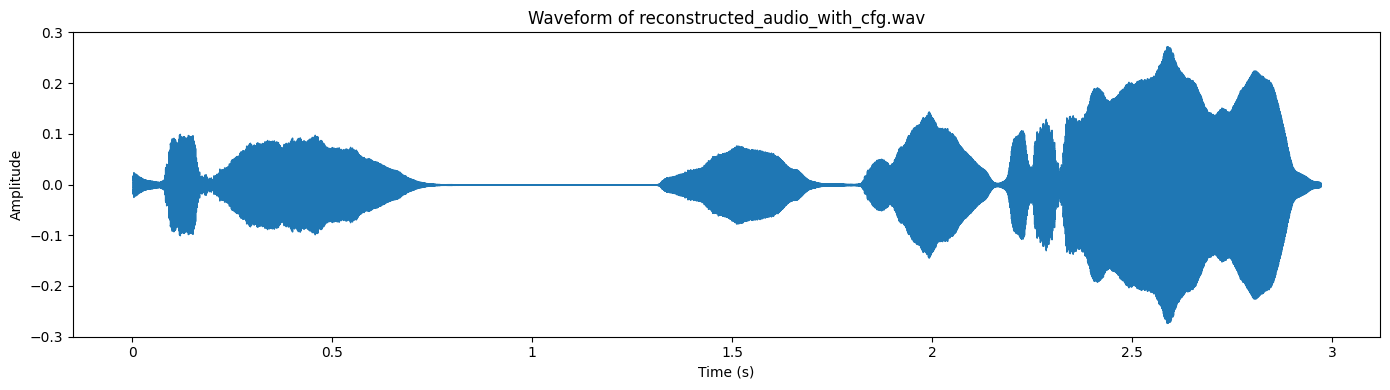

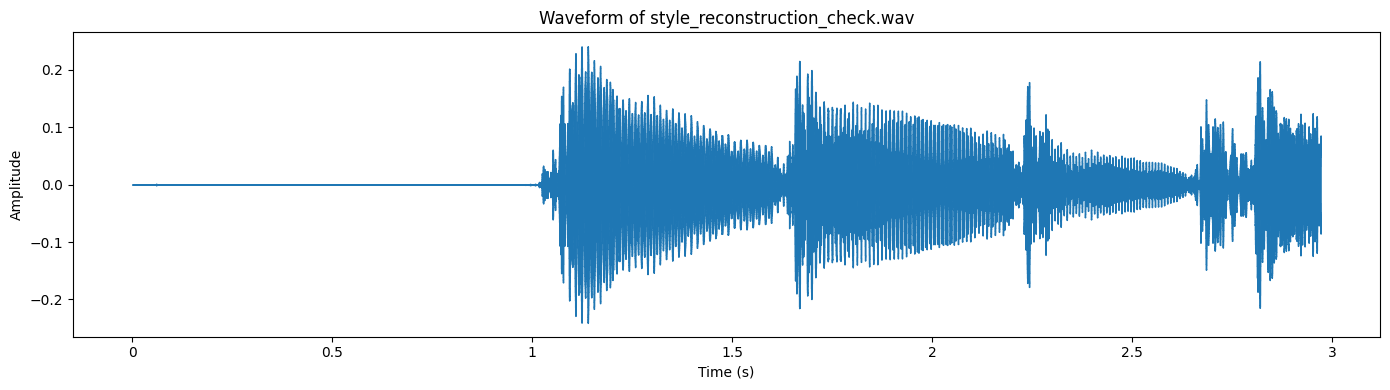

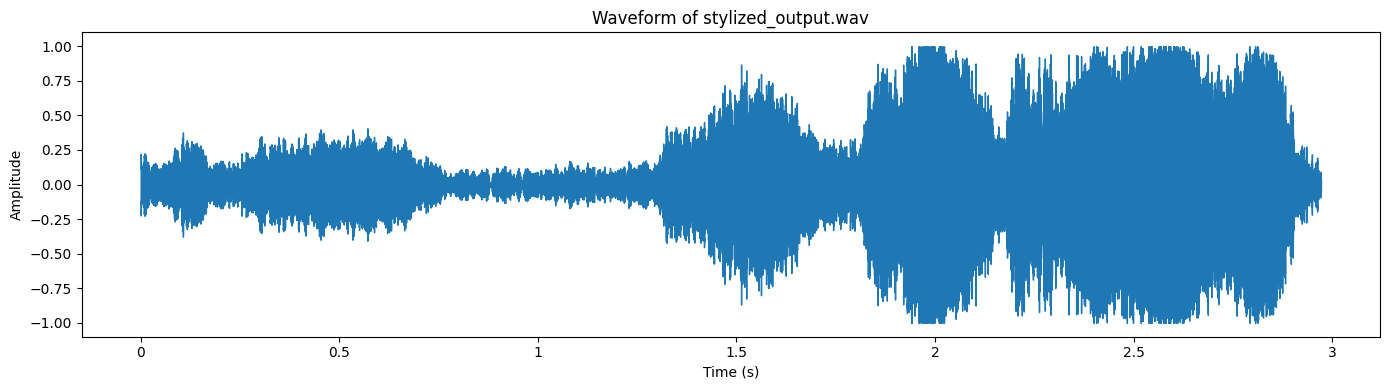

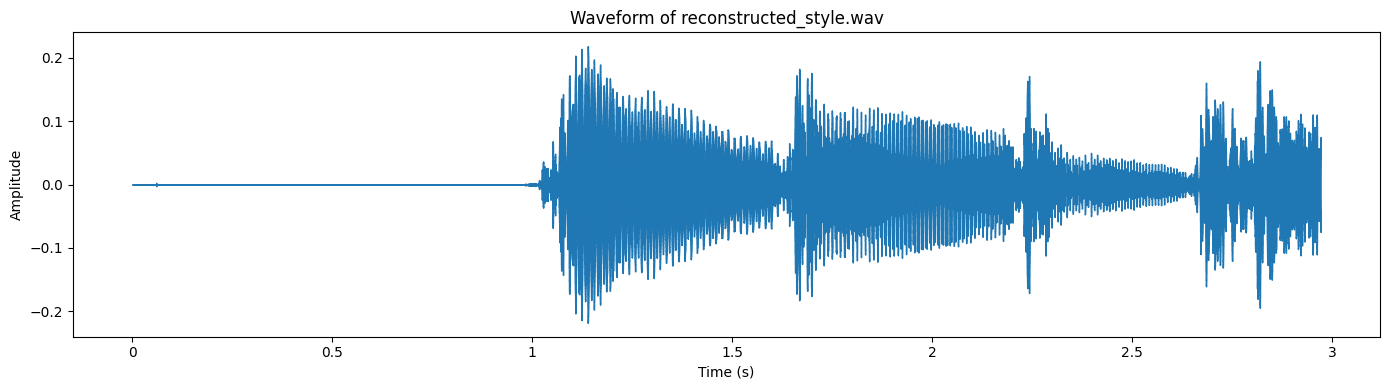

In [5]:
from helpers import load_and_view_audio 
load_and_view_audio("reconstructed_audio_with_cfg.wav")
load_and_view_audio("style_reconstruction_check.wav")
load_and_view_audio("stylized_output.wav")
load_and_view_audio("reconstructed_style.wav")